In [1]:
# load libraries
import glob
import numpy as np
import pandas as pd
from tqdm import tqdm
import os
import re
import pdb

# For plotting
import matplotlib.pyplot as plt

# for statistical analysis
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression


# #uncertainties packages
# from uncertainties import ufloat
# from uncertainties.umath import *  #e.g. sqrt()
# from uncertainties import unumpy

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.options.display.float_format = '{:.2f}'.format
from IPython.core.display import display, HTML
# uncomment this line and run the cell --> fit the cells to screen. Comment and re-run to disable full width.
# display(HTML("<style>.container { width:100% !important; }</style>"))
plt.style.use('seaborn-darkgrid')

## Input

In [2]:
## probably not usable class_id: 26, 56
## input
data_path = "../data"
input_path = f"{data_path}/experiment-result-2021-06-15.csv"
input_path_uncomp = f"{data_path}/experiment-uncomp-06-14-2021.csv"
visual_metric = "MOTA"
averaged_result_class = "all"

## Data Preparation to get "all" object categories

In [3]:
df = pd.read_csv(input_path, sep=',')
df_uncomp = pd.read_csv(input_path_uncomp, sep=',')
df = pd.concat([df_uncomp, df])
df['F1'] = 2 * df['Prcn'] * df['Rcll'] / (df['Prcn'] + df['Rcll'])
df['MOTP'] = ( 1 - df['MOTP'] ) * 100
# filter df
header = ['class_cat', 'seq_name', 'class_id', 'qp', 'msr', 'idtp', 'idfp', 'idfn', 'IDF1', 'IDP', 'IDR',
          'Rcll', 'Prcn', 'F1', 'GT', 'MT', 'PT', 'ML', 'num_detections', 'FP', 'FN', 'IDs', 'FM', 'mAP', 'MOTA', 'MOTP']
# re-arrange
df = df[header]
# rename
df.columns = ['class_cat', 'seq_name', 'class_id', 'QP', 'MSR', 'IDTP', 'IDFP', 'IDFN', 'IDF1', 'IDP', 'IDR',
          'Recall', 'Precision', 'F1', 'GT', 'MT', 'PT', 'ML', 'TP', 'FP', 'FN', 'IDs', 'FM', 'mAP-50', 'MOTA', 'MOTP']

df_all = df[df['class_id'] == 'all']
df_all.reset_index(inplace=True, drop=True)
df_all

,class_cat,seq_name,class_id,QP,MSR,IDTP,IDFP,IDFN,IDF1,IDP,IDR,Recall,Precision,F1,GT,MT,PT,ML,TP,FP,FN,IDs,FM,mAP-50,MOTA,MOTP
0,ClassB,BasketballDrive,all,0,0,1358.00,1997.00,2987.00,35.30,40.50,31.30,67.10,87.10,75.80,17,5,9,3,2917,431,1428,83,103,58.13,55.30,81.30
1,ClassB,Cactus,all,0,0,120.00,232.00,380.00,28.20,34.10,24.00,60.20,85.50,70.65,1,0,1,0,301,51,199,7,11,67.96,48.60,88.20
2,ClassB,Kimono,all,0,0,140.00,95.00,222.00,46.90,59.60,38.70,64.90,100.00,78.71,2,1,0,1,235,0,127,1,1,51.14,64.60,85.70
3,ClassB,ParkScene,all,0,0,631.00,181.00,870.00,54.80,77.70,42.00,52.80,98.60,68.77,10,5,2,3,792,11,709,15,26,71.93,51.00,82.10
4,ClassC,BasketballDrill,all,0,0,824.00,1521.00,4201.00,22.40,35.10,16.40,43.50,93.50,59.38,11,3,4,4,2186,153,2839,56,78,41.79,39.30,79.60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
391,ClassE,KristenAndSara,all,42,64,2675.00,1210.00,6332.00,41.50,68.90,29.70,31.50,72.90,43.99,17,4,1,12,2833,1052,6174,3,17,41.95,19.70,75.10
392,ClassE,KristenAndSara,all,46,8,1595.00,770.00,7412.00,28.10,67.40,17.70,22.00,83.80,34.85,17,3,1,13,1982,383,7025,9,15,37.95,17.70,79.60
393,ClassE,KristenAndSara,all,46,16,1888.00,506.00,7119.00,33.10,78.90,21.00,22.90,86.30,36.20,17,3,1,13,2065,329,6942,5,20,39.29,19.20,78.40
394,ClassE,KristenAndSara,all,46,32,1543.00,894.00,7464.00,27.00,63.30,17.10,21.50,79.40,33.84,17,3,1,13,1935,502,7072,15,25,36.09,15.70,80.30


## 1.1 Multiple Linear Regression (Uncompressed - MOTA (QP = qp))

$ \text{Score'} = c_0 + c_1 \cdot \text{QP}' + c_2 \cdot \text{MSR} + c_3 \cdot \text{QP}' \cdot \text{MSR} + \epsilon $

where QP' is the transformed parameter of QP to linealize

$ \text{QP}' = \frac{1}{\frac{\text{QP}}{52} -1} $ 

and Score is transformed such that:

$ \text{Score'} = \text{Score (QP = qp)} - \text{Score (QP = "Uncompressed")} $ (for IDFN, FN, ML, PT)

$ \text{Score'} = \text{Score (QP = "Uncompressed")} - \text{Score (QP = qp)} $ (else)

### Claim:

For MOTA,

$ \text{MOTA'} = c_0 + c_1 \cdot \frac{1}{\frac{\text{QP}}{52} -1} $

$ ( \text{MOTA} = c_0 + c_1 \cdot \frac{1}{\frac{\text{QP}}{52} -1}  )$

$ 54.49 - \text{MOTA} = c_0 + c_1 \cdot \frac{1}{\frac{\text{QP}}{52} -1} $

$ \text{MOTA} = 54.49 - (-4.32 - 2.97 \cdot \frac{1}{\frac{\text{QP}}{52} -1} ) $

$ \text{MOTA} = 58.81 + 2.97 \cdot \frac{1}{\frac{\text{QP}}{52} -1} $

In [4]:
# from statsmodels.stats.weightstats import ttest_ind
import scipy

df = pd.read_csv(input_path, sep=',')
df_uncomp = pd.read_csv(input_path_uncomp, sep=',')
df = pd.concat([df_uncomp, df])
df['F1'] = 2 * df['Prcn'] * df['Rcll'] / (df['Prcn'] + df['Rcll'])
df['MOTP'] = ( 1 - df['MOTP'] ) * 100
# filter df
header = ['class_cat', 'seq_name', 'class_id', 'qp', 'msr', 'idtp', 'idfp', 'idfn', 'IDF1', 'IDP', 'IDR',
          'Rcll', 'Prcn', 'F1', 'GT', 'MT', 'PT', 'ML', 'num_detections', 'FP', 'FN', 'IDs', 'FM', 'mAP', 'MOTA', 'MOTP']
# re-arrange
df = df[header]
# rename
df.columns = ['class_cat', 'seq_name', 'class_id', 'QP', 'MSR', 'IDTP', 'IDFP', 'IDFN', 'IDF1', 'IDP', 'IDR',
          'Recall', 'Precision', 'F1', 'GT', 'MT', 'PT', 'ML', 'TP', 'FP', 'FN', 'IDs', 'FM', 'mAP-50', 'MOTA', 'MOTP']

df_all = df[df['class_id'] == 'all']
df_all.reset_index(inplace=True, drop=True)
df_all['QP_transform'] = 1 / (df_all['QP'] / 52 - 1)

df_all['QP_transform*MSR'] = df_all['QP_transform'] * df_all['MSR']

qp_list = [18, 22, 26, 30, 34, 38, 42, 46]

# take the difference between compressed and uncompressed
df_all_diff = df_all.copy()
for metric in df_all_diff:
    if metric == 'GT' or metric == "class_cat" or metric == "seq_name" or metric=="class_id" or metric == "QP" or metric == "QP_transform" or metric == "MSR" or metric == "QP_transform*MSR":
        continue

    for i in df_all.index:
    #     ind = (df_all['class_cat'] == df_all.loc[i, 'class_cat']) &  (df_all['seq_name'] == df_all.loc[i, 'seq_name']) & (df_all['QP'] == 0)
        class_cat = df_all.loc[i, 'class_cat']
        seq_name = df_all.loc[i, 'seq_name']
        uncomp_val = float(df_all.query(f'class_cat == "{class_cat}" and seq_name == "{seq_name}" and QP == 0')[metric])
        
        if metric == "IDFN" or metric == "FN" or metric == "ML" or metric == "PT":
            df_all_diff.loc[i, metric] =  df_all.loc[i, metric] - uncomp_val
        else:
            df_all_diff.loc[i, metric] = uncomp_val - df_all.loc[i, metric]

C:\Users\Takehiro\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Takehiro\Miniconda3\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [5]:
df_stats = pd.DataFrame([])
header = ['QP', 'QP_transform', 'MSR', 'QP_transform*MSR', 'IDTP', 'IDFP', 'IDFN', 'IDF1', 'IDP', 'IDR',
          'Recall', 'Precision', 'F1', 'MT', 'PT', 'ML', 'TP', 'FP', 'FN', 'IDs', 'FM', 'mAP-50', 'MOTA', 'MOTP']
metric_list = ['IDTP', 'IDFP', 'IDFN', 'IDF1', 'IDP', 'IDR',
          'Recall', 'Precision', 'F1', 'MT', 'PT', 'ML', 'TP', 'FP', 'FN', 'IDs', 'FM', 'mAP-50', 'MOTA', 'MOTP']
df_all_avg = df_all_diff.query('QP > 0')[header]
for metric in metric_list:
#     if metric == "MOTA": # do only for MOTA
    if True: # do all metrics not only MOTA

        # r-style method
        #result = smf.ols(formula=f"{metric} ~ QP_transform + MSR + QP_transform * MSR", data=df_all_avg).fit()

        # OLS method
    #         y = df_all_avg[metric]
    #         X = df_all_avg[['QP_transform', 'MSR', 'QP_transform*MSR']]
    #         X = sm.add_constant(X)
    #         result = sm.OLS(y, X).fit()

        # WLS method
        y = df_all_avg[metric]
        X = df_all_avg[['QP_transform', 'MSR', 'QP_transform*MSR']]
        X = sm.add_constant(X)

        # compute the weight w for the specific metric
        qp_transform_list = list(set(df_all_avg['QP_transform']))
        for qp_transform in qp_transform_list:
            # computing the weight w = 1 / (sample variance at each QP_transform)
            w_at_qp_transform = 1 / np.var(df_all_avg.query(f'QP_transform == {qp_transform}')[metric], ddof=1)
            df_all_avg.loc[(df_all_avg['QP_transform'] == qp_transform), 'w'] = w_at_qp_transform
        w = df_all_avg['w']
    #         w = np.ones(len(y)) # 1 .. same as OLS
        result = sm.WLS(y, X, w).fit()

        series = result.params
        series['p-value(Intercept)'] =  result.pvalues[0]
        series['p-value(QP)'] =  result.pvalues[1]
        series['p-value(MSR)'] =  result.pvalues[2]
        series['p-value(QP*MSR)'] =  result.pvalues[3]
    #         series['rsquared'] = result.rsquared
        df_stats[metric] = series
        df_stats.fillna(1.0, inplace=True)

df_stats.index = ['parameter(Intercept)', 'parameter(QP\')', 'parameter(MSR)', 'parameter(QP\'*MSR)',
                  'p-value(Intercept)', 'p-value(QP\')', 'p-value(MSR)', 'p-value(QP\'*MSR)']

# df_stats.index = ['$\\beta_0$', '$\\beta_1$', '$\\beta_2$', '$\\beta_3$',
#                   'p-value($\\beta_0$)', 'p-value($\\beta_1$)', 'p-value($\\beta_2$)', 'p-value($\\beta_3$)']


display(df_stats)
# print(df_stats.to_latex(index=True, multirow=True, escape=False, multicolumn_format='c'))
print(w)

,IDTP,IDFP,IDFN,IDF1,IDP,IDR,Recall,Precision,F1,MT,PT,ML,TP,FP,FN,IDs,FM,mAP-50,MOTA,MOTP
parameter(Intercept),-173.56,-79.55,-173.56,-5.58,-1.67,-6.14,-5.71,1.09,-3.76,-0.54,0.04,-0.59,-162.88,-61.11,-162.88,-2.09,-1.90,-6.23,-4.32,-0.22
parameter(QP'),-100.23,-48.83,-100.23,-2.79,-0.49,-3.31,-3.71,0.66,-2.50,-0.40,0.05,-0.45,-107.25,-28.81,-107.25,-1.05,-1.11,-3.82,-2.97,-0.07
parameter(MSR),0.11,-0.17,0.11,0.01,0.01,0.01,-0.00,-0.00,-0.01,-0.00,-0.00,0.00,-0.25,-0.04,-0.25,-0.01,-0.02,-0.00,-0.01,0.00
parameter(QP'*MSR),-0.04,0.00,-0.04,0.00,0.00,0.00,-0.00,-0.00,-0.00,-0.00,-0.00,0.00,-0.11,0.00,-0.11,-0.01,-0.00,-0.00,-0.00,0.00
p-value(Intercept),0.00,0.01,0.00,0.00,0.10,0.00,0.00,0.04,0.00,0.00,0.79,0.00,0.00,0.00,0.00,0.01,0.10,0.00,0.00,0.08
p-value(QP'),0.00,0.00,0.00,0.00,0.14,0.00,0.00,0.00,0.00,0.00,0.45,0.00,0.00,0.00,0.00,0.00,0.02,0.00,0.00,0.32
p-value(MSR),0.92,0.84,0.92,0.64,0.72,0.71,0.90,0.82,0.77,0.89,0.82,0.85,0.72,0.93,0.72,0.56,0.47,0.96,0.83,0.59
p-value(QP'*MSR),0.95,1.00,0.95,0.72,0.73,0.81,0.89,0.51,0.77,0.83,0.76,0.90,0.80,0.98,0.80,0.53,0.71,0.97,0.77,0.64


12    31.34
13    31.34
14    31.34
15    31.34
16     7.07
       ... 
391    0.23
392    0.08
393    0.08
394    0.08
395    0.08
Name: w, Length: 384, dtype: float64


In [6]:
# print(df_stats.to_latex(index=True, multirow=True, escape=False, multicolumn_format='c'))

# def bold(x):
#     format_string = "%.2f"
#     if abs(x) <= 0.05:
#         str_cell =  "\\textbf{%s}" % format_string % x
#     else:
#         str_cell = "%s" % format_string % x
#     return str_cell 

# for metric in df_stats.columns:
#     df_stats[metric] = df_stats[metric].apply(bold)

# print(df_stats.to_latex(index=True, multirow=True, escape=False, multicolumn_format='c'))


### Compute the weight w for the specific metric

In [7]:
metric = "MOTA"
qp_transform_list = list(set(df_all_avg['QP_transform']))
for qp_transform in qp_transform_list:
    # computing the weight w = 1 / (sample variance at each QP_transform)
    w_at_qp_transform = 1 / np.var(df_all_avg.query(f'QP_transform == {qp_transform}')[metric], ddof=1)
    df_all_avg.loc[(df_all_avg['QP_transform'] == qp_transform), 'w_MOTA'] = w_at_qp_transform
display(df_all_avg[['QP', 'QP_transform', 'MSR','MOTA', 'w_MOTA']].reset_index(drop=True))
w = df_all_avg['w_MOTA']

,QP,QP_transform,MSR,MOTA,w_MOTA
0,18,-1.53,8,0.10,0.36
1,18,-1.53,16,0.00,0.36
2,18,-1.53,32,-0.50,0.36
3,18,-1.53,64,-0.20,0.36
4,22,-1.73,8,0.10,0.13
...,...,...,...,...,...
379,42,-5.20,64,-6.20,0.01
380,46,-8.67,8,-4.20,0.00
381,46,-8.67,16,-5.70,0.00
382,46,-8.67,32,-2.20,0.00


## 1.2 Check the adequacy of the model (residual analysis)

Mean is trivial because mean = 0, so this test is not really adequate.

Variance is not trivial.

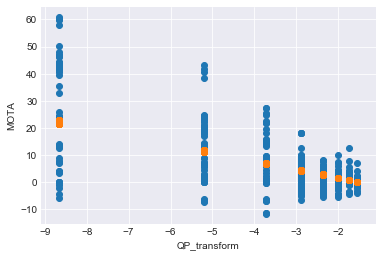

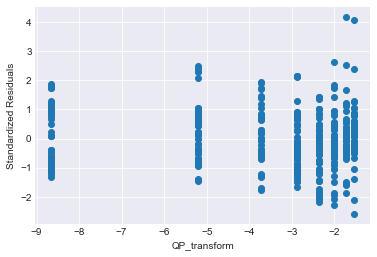

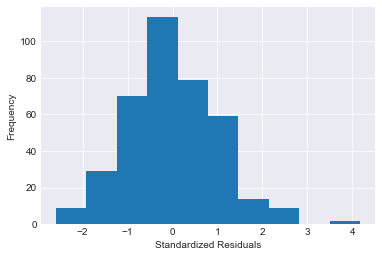

In [8]:
metric = "MOTA"
x = df_all_avg['QP_transform']
y = df_all_avg[metric]
plt.scatter(x, y)

beta0 = df_stats.loc['parameter(Intercept)', metric]
beta1 = df_stats.loc['parameter(QP\')', metric]
beta2 = df_stats.loc['parameter(MSR)', metric]
beta3 = df_stats.loc['parameter(QP\'*MSR)', metric]
y_fit = beta0 + beta1 * df_all_avg['QP_transform'] + beta2 * df_all_avg['MSR'] + beta3 * df_all_avg['QP_transform'] * df_all_avg['MSR']
plt.scatter(x, y_fit)
plt.xlabel("QP_transform")
plt.ylabel("MOTA")
plt.show()

# studentized residual
residual = ( y - y_fit ) * np.sqrt(w)
plt.scatter(x, residual)
plt.xlabel("QP_transform")
plt.ylabel("Standardized Residuals")
plt.show()
plt.hist(residual)
plt.xlabel("Standardized Residuals")
plt.ylabel("Frequency")
plt.show()

## 1.3 Check the adequacy of the model (normal probablity plot)



Got = [0.00211948 0.99726014]

r^2 = 0.9847792400117903

The plot looks good, so the error term $\epsilon$

$ \text{MOTA} = c_0 + c_1 \cdot \text{QP}' + c_2 \cdot \text{MSR} + c_3 \cdot \text{QP}' \cdot \text{MSR} + \epsilon $

$\epsilon$ is random (normally distributed) therefore, the equation above, our model is adequate. 

,QP,QP_transform,MSR,MOTA,MOTA_fit,w_MOTA
0,18,-1.53,8,0.10,0.22,0.36
1,18,-1.53,16,0.00,0.22,0.36
2,18,-1.53,32,-0.50,0.23,0.36
3,18,-1.53,64,-0.20,0.24,0.36
4,22,-1.73,8,0.10,0.83,0.13
...,...,...,...,...,...,...
379,42,-5.20,64,-6.20,12.00,0.01
380,46,-8.67,8,-4.20,21.64,0.00
381,46,-8.67,16,-5.70,21.85,0.00
382,46,-8.67,32,-2.20,22.27,0.00


beta0 =  -4.324457111342321
beta1 =  -2.9715170219555516
beta2 =  -0.0053172936528347176
beta3 =  -0.003649878354063843
At i = 0, MOTA_fit =  23.11284947887844


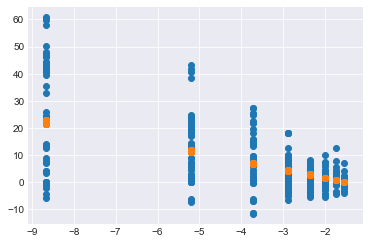

In [9]:
metric = "MOTA"

df_all_avg = df_all_avg.reset_index(drop=True)

# get y_fit
beta0 = df_stats.loc['parameter(Intercept)', metric]
beta1 = df_stats.loc['parameter(QP\')', metric]
beta2 = df_stats.loc['parameter(MSR)', metric]
beta3 = df_stats.loc['parameter(QP\'*MSR)', metric]
y_fit = beta0 + beta1 * df_all_avg['QP_transform'] + beta2 * df_all_avg['MSR'] + beta3 * df_all_avg['QP_transform'] * df_all_avg['MSR']

# get w
qp_transform_list = list(set(df_all_avg['QP_transform']))
for qp_transform in qp_transform_list:
    # computing the weight w = 1 / (sample variance at each QP_transform)
    w_at_qp_transform = 1 / np.var(df_all_avg.query(f'QP_transform == {qp_transform}')[metric], ddof=1)
    df_all_avg.loc[(df_all_avg['QP_transform'] == qp_transform), 'w_MOTA'] = w_at_qp_transform
df_all_avg['MOTA_fit'] = y_fit

display(df_all_avg[['QP', 'QP_transform', 'MSR','MOTA', 'MOTA_fit', 'w_MOTA']].reset_index(drop=True))
w = df_all_avg['w_MOTA']
print('beta0 = ', beta0)
print('beta1 = ', beta1)
print('beta2 = ', beta2)
print('beta3 = ', beta3)

i = 383
print("At i = 0, MOTA_fit = ", beta0 + beta1 * df_all_avg.loc[i, 'QP_transform'] + beta2 * df_all_avg.loc[i, 'MSR'] + beta3 *  df_all_avg.loc[i, 'QP_transform'] *  df_all_avg.loc[i, 'MSR'])

plt.scatter(df_all_avg['QP_transform'], df_all_avg['MOTA'])
plt.scatter(df_all_avg['QP_transform'], df_all_avg['MOTA_fit'])

MSE_sqrt =  1.0089786094290483
[0.00405691 1.00115438]
0.9851783725547589


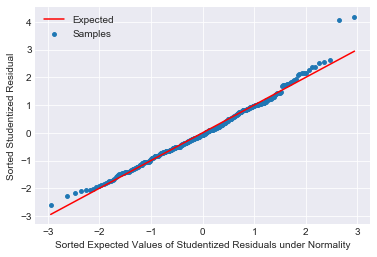

In [11]:
import scipy

# summarize
w = df_all_avg['w_MOTA']
y = df_all_avg['MOTA']
y_fit = df_all_avg['MOTA_fit']

w = np.array(w)
y = np.array(y)
y_fit = np.array(y_fit)

# calculate the weighted MSE
MSE = 0
for i in range(len(y)):
    MSE += w[i] * ( y[i] - y_fit[i] ) ** 2 / (len(y) - 4)
MSE_sqrt = np.sqrt(MSE)
print("MSE_sqrt = ", MSE_sqrt)

sorted_std_res = np.sort( (y-y_fit) * np.sqrt(w))
z = scipy.stats.norm.ppf( (np.arange(1,385) - 0.375) / (len(y) + 0.25)  )

plt.scatter(z, sorted_std_res, s=15, label='Samples')
plt.plot(z,z, c='r', label='Expected')
plt.xlabel('Sorted Expected Values of Studentized Residuals under Normality')
plt.ylabel('Sorted Studentized Residual')
plt.legend()
y = sorted_std_res
X = z
X = sm.add_constant(X)
result = sm.OLS(y, X).fit()
print(result.params)
print(result.rsquared)
plt.savefig("C:/OneDrive/SFU/ENSC498, 499/images/normal_probability_plot.pdf", bbox_inches="tight")

C:\Users\Takehiro\Miniconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  


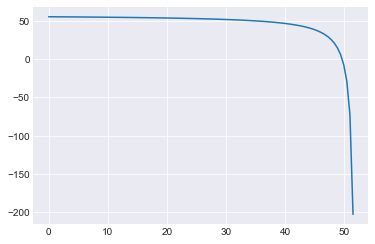

In [51]:
x = np.linspace(0, 52, 100)
plt.plot(x, 58.32 + 2.64 * 1 / ( x / 52 - 1) )

## QP Transformation


Determination of QP transformation equation with trial and error

QP = 52 was chosen for the division factor because if we use QP = 51, the term QP / 51 term will blow up. 

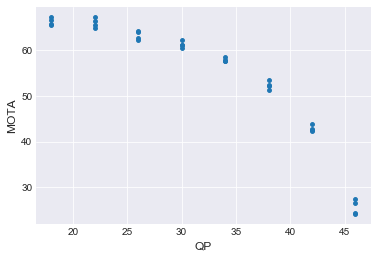

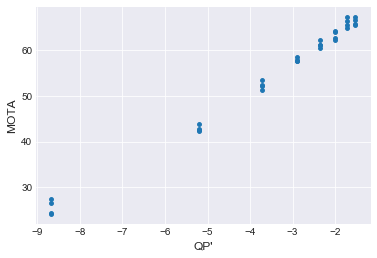

In [7]:
seq_name = "BasketballPass"
df_all_seq = df_all.query(f'seq_name == "{seq_name}"')
df_all_seq_comp = df_all_seq.query('QP != 0 and MSR != 0')

QP = df_all_seq_comp['QP']
x = 1 / (QP / 52 - 1)
y = df_all_seq_comp['MOTA']

plt.clf()
plt.scatter(QP, y, s=15)
plt.xlabel('QP', fontsize=12)
plt.ylabel('MOTA', fontsize=12)
plt.savefig("C:/OneDrive/SFU/ENSC498, 499/images/QP_transformation_before.pdf", bbox_inches="tight")
plt.show()

plt.clf()
plt.scatter(x, y, s=15)
plt.xlabel('QP\'', fontsize=12)
plt.ylabel('MOTA', fontsize=12)
plt.savefig("C:/OneDrive/SFU/ENSC498, 499/images/QP_transformation_after.pdf", bbox_inches="tight")
plt.show()

## MOTA transformation

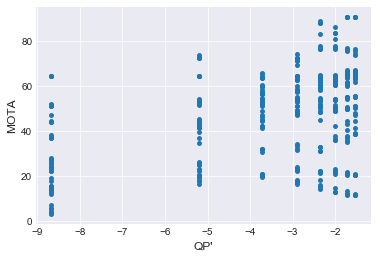

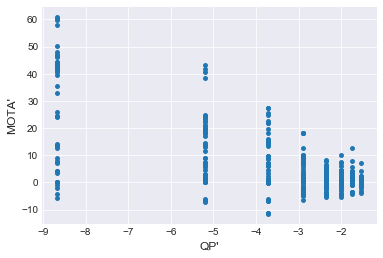

In [8]:
plt.clf()
x = df_all_avg.query(' QP > 0')['QP_transform']
y = df_all.query(' QP > 0')['MOTA']
plt.scatter(x, y, s=15)
plt.xlabel('QP\'', fontsize=12)
plt.ylabel('MOTA', fontsize=12)
plt.savefig("C:/OneDrive/SFU/ENSC498, 499/images/MOTA_transformation_before.pdf", bbox_inches="tight")
plt.show()

plt.clf()
x = df_all_avg.query(' QP > 0')['QP_transform']
y = df_all_avg.query(' QP > 0')['MOTA']
plt.scatter(x, y, s=15)
plt.xlabel('QP\'', fontsize=12)
plt.ylabel('MOTA\'', fontsize=12)
plt.savefig("C:/OneDrive/SFU/ENSC498, 499/images/MOTA_transformation_after.pdf", bbox_inches="tight")
plt.show()

## 2. Multiple Linear Regression (ensemble learning way)

$ \text{Score} = c_0 + c_1 \cdot \text{QP}' + c_2 \cdot \text{MSR} + c_3 \cdot \text{QP}' \cdot \text{MSR} $

where QP' is the transformed parameter of QP to linealize

$ \text{QP}' = \frac{1}{\frac{\text{QP}}{51} -1} $ 

C:\Users\Takehiro\Miniconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Takehiro\Miniconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Takehiro\Miniconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://panda

,IDTP,IDFP,IDFN,IDF1,IDP,IDR,Recall,Precision,F1,MT,PT,ML,TP,FP,FN,IDs,FM,mAP50,MOTA,MOTP
coefficient(Intercept),1898.01,986.82,2387.24,54.49,62.50,47.69,67.31,90.08,77.72,4.98,3.27,3.99,2414.64,466.18,1870.61,25.37,36.24,69.42,59.60,82.78
coefficient(QP),84.49,36.51,-84.49,2.33,0.36,2.54,3.39,0.06,3.08,0.32,0.03,-0.35,105.16,15.84,-105.16,0.74,0.79,3.24,3.11,0.24
coefficient(MSR),0.13,-0.26,-0.13,0.00,0.01,-0.00,-0.00,-0.00,-0.00,0.00,-0.00,0.00,-0.06,-0.07,0.06,-0.01,0.01,-0.00,-0.00,-0.00
coefficient(QP*MSR),0.09,-0.13,-0.09,0.00,0.00,0.00,-0.00,0.00,0.00,0.00,-0.00,0.00,-0.01,-0.03,0.01,-0.00,0.00,-0.00,0.00,-0.00
p-value(Intercept),0.00,0.00,0.05,0.00,0.00,0.00,0.00,0.00,0.00,0.08,0.19,0.26,0.00,0.03,0.04,0.02,0.07,0.00,0.00,0.00
p-value(QP),0.03,0.10,0.03,0.04,0.15,0.03,0.02,0.15,0.06,0.09,0.18,0.14,0.03,0.20,0.03,0.13,0.12,0.01,0.04,0.18
p-value(MSR),0.57,0.60,0.57,0.54,0.48,0.57,0.68,0.71,0.66,0.56,0.60,0.61,0.68,0.73,0.68,0.57,0.57,0.77,0.72,0.68
p-value(QP*MSR),0.56,0.55,0.56,0.48,0.37,0.55,0.59,0.62,0.49,0.58,0.53,0.58,0.59,0.71,0.59,0.54,0.47,0.71,0.59,0.55


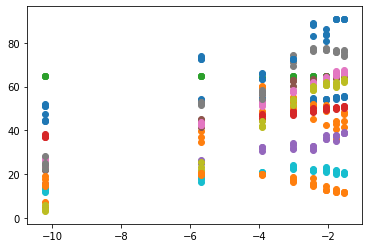

In [17]:
seq_name_list = ['BasketballDrive', 'Cactus', 'Kimono', 'ParkScene',
        'BasketballDrill', 'RaceHorsesC',
        'BasketballPass', 'BlowingBubbles', 'RaceHorsesD',
        'FourPeople', 'Johnny', 'KristenAndSara']

header = ['QP', 'QP_transform', 'MSR', 'IDTP', 'IDFP', 'IDFN', 'IDF1', 'IDP', 'IDR',
          'Recall', 'Precision', 'F1', 'MT', 'PT', 'ML', 'TP', 'FP', 'FN', 'IDs', 'FM', 'mAP50', 'MOTA', 'MOTP']

df_stats_list = []
for seq_name in seq_name_list:
    df_all_seq = df_all.query(f'seq_name == "{seq_name}"')
    df_all_seq_comp = df_all_seq.query('QP != 0 and MSR != 0')

    df_all_seq_comp['QP_transform'] = 1 / (df_all_seq_comp['QP'] / 51 - 1)
    
    plt.scatter(df_all_seq_comp['QP_transform'], df_all_seq_comp['MOTA'])

    df_stats = pd.DataFrame([])
    df_all_avg = df_all_seq_comp[header]
    for metric in df_all_avg:
        if metric != 'QP' and metric != 'MSR' and metric != 'QP_transform':
            result = smf.ols(formula=f"{metric} ~ QP_transform + MSR + QP_transform * MSR", data=df_all_avg).fit()
            series = result.params
            series['p-value(Intercept)'] =  result.pvalues[0]
            series['p-value(QP)'] =  result.pvalues[1]
            series['p-value(MSR)'] =  result.pvalues[2]
            series['p-value(QP:msr)'] =  result.pvalues[3]
            #series['rsquared'] = result.rsquared
            df_stats[metric] = series
            
            # replace NaN with 1.0 since coefficient is 0
            df_stats.fillna(1.0, inplace=True)

    df_stats.index = ['coefficient(Intercept)', 'coefficient(QP)', 'coefficient(MSR)', r'coefficient(QP*MSR)',
                      'p-value(Intercept)', 'p-value(QP)', 'p-value(MSR)', r'p-value(QP*MSR)']

    df_stats_list.append(df_stats)
    # print(df_stats.to_latex(index=True, multirow=True))
#     display(df_stats)
sum(df_stats_list) / 12

## 3. Multiple Linear Regression (Derivative) 

In [152]:
# from statsmodels.stats.weightstats import ttest_ind
import scipy
from numpy import diff

df = pd.read_csv(input_path, sep=',')
df_uncomp = pd.read_csv(input_path_uncomp, sep=',')
df = pd.concat([df_uncomp, df])
df['F1'] = 2 * df['Prcn'] * df['Rcll'] / (df['Prcn'] + df['Rcll'])
df['MOTP'] = ( 1 - df['MOTP'] ) * 100
# filter df
header = ['class_cat', 'seq_name', 'class_id', 'qp', 'msr', 'idtp', 'idfp', 'idfn', 'IDF1', 'IDP', 'IDR',
          'Rcll', 'Prcn', 'F1', 'GT', 'MT', 'PT', 'ML', 'num_detections', 'FP', 'FN', 'IDs', 'FM', 'mAP', 'MOTA', 'MOTP']
# re-arrange
df = df[header]
# rename
df.columns = ['class_cat', 'seq_name', 'class_id', 'QP', 'MSR', 'IDTP', 'IDFP', 'IDFN', 'IDF1', 'IDP', 'IDR',
          'Recall', 'Precision', 'F1', 'GT', 'MT', 'PT', 'ML', 'TP', 'FP', 'FN', 'IDs', 'FM', 'mAP50', 'MOTA', 'MOTP']

df_all = df[df['class_id'] == 'all']
df_all.reset_index(inplace=True, drop=True)
df_all['QP_transform'] = 1 / (df_all['QP'] / 51 - 1)

qp_list = [18, 22, 26, 30, 34, 38, 42, 46]
msr_list = [8, 16, 32, 64]
seq_name_list = ['BasketballDrive', 'Cactus', 'Kimono', 'ParkScene',
        'BasketballDrill', 'RaceHorsesC',
        'BasketballPass', 'BlowingBubbles', 'RaceHorsesD',
        'FourPeople', 'Johnny', 'KristenAndSara']
header = list(df_all.iloc[:,5:])



# take the difference between compressed and uncompressed
df_all_diff = df_all.copy()
# df_all_diff = pd.DataFrame(columns=list(df_all.columns))
for metric in header:
    if metric == 'GT':
        continue
    for seq_name in seq_name_list:
        for msr in msr_list:
            x = df_all_diff.query(f'seq_name == "{seq_name}" and MSR == {msr}')['QP']
            y = df_all_diff.query(f'seq_name == "{seq_name}" and MSR == {msr}')[metric]
            df_all_diff.loc[(df_all_diff['seq_name'] == f"{seq_name}") & (df_all_diff['MSR'] == msr), metric] = np.gradient(y,x)

display(df_all_diff)

C:\Users\Takehiro\Miniconda3\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,class_cat,seq_name,class_id,QP,MSR,IDTP,IDFP,IDFN,IDF1,IDP,IDR,Recall,Precision,F1,GT,MT,PT,ML,TP,FP,FN,IDs,FM,mAP50,MOTA,MOTP,QP_transform
0,ClassB,BasketballDrive,all,0,0,1358.00,1997.00,2987.00,35.30,40.50,31.30,67.10,87.10,75.80,17,5.00,9.00,3.00,2917.00,431.00,1428.00,83.00,103.00,58.13,55.30,81.30,-1.00
1,ClassB,Cactus,all,0,0,120.00,232.00,380.00,28.20,34.10,24.00,60.20,85.50,70.65,1,0.00,1.00,0.00,301.00,51.00,199.00,7.00,11.00,67.96,48.60,88.20,-1.00
2,ClassB,Kimono,all,0,0,140.00,95.00,222.00,46.90,59.60,38.70,64.90,100.00,78.71,2,1.00,0.00,1.00,235.00,0.00,127.00,1.00,1.00,51.14,64.60,85.70,-1.00
3,ClassB,ParkScene,all,0,0,631.00,181.00,870.00,54.80,77.70,42.00,52.80,98.60,68.77,10,5.00,2.00,3.00,792.00,11.00,709.00,15.00,26.00,71.93,51.00,82.10,-1.00
4,ClassC,BasketballDrill,all,0,0,824.00,1521.00,4201.00,22.40,35.10,16.40,43.50,93.50,59.38,11,3.00,4.00,4.00,2186.00,153.00,2839.00,56.00,78.00,41.79,39.30,79.60,-1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
391,ClassE,KristenAndSara,all,42,64,-168.62,-65.12,168.62,-2.10,-0.38,-1.86,-1.65,0.89,-1.70,17,-0.25,0.00,0.25,-148.62,-85.12,148.62,0.88,2.00,-1.05,-0.71,0.45,-0.78
392,ClassE,KristenAndSara,all,46,8,-297.75,-118.25,297.75,-3.65,-0.42,-3.30,-2.65,2.75,-2.55,17,-0.50,0.25,0.25,-238.25,-177.75,238.25,1.75,0.00,-1.07,-0.67,1.28,-1.13
393,ClassE,KristenAndSara,all,46,16,-183.25,-172.75,183.25,-1.95,2.58,-2.03,-2.08,3.15,-1.91,17,-0.25,0.00,0.25,-187.25,-168.75,187.25,0.25,1.00,-0.64,-0.23,0.83,-1.13
394,ClassE,KristenAndSara,all,46,32,-260.50,-64.75,260.50,-3.40,-1.48,-2.90,-2.40,1.12,-2.53,17,-0.25,0.00,0.25,-215.75,-109.50,215.75,2.75,3.75,-1.38,-1.23,1.30,-1.13


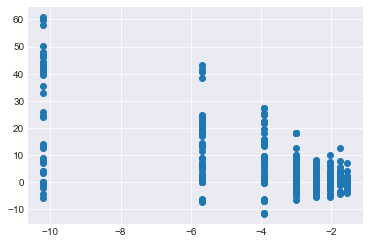

In [83]:
x = df_all_diff.query(' QP > 0')['QP_transform']
y = df_all_diff.query(' QP > 0')['MOTA']
plt.scatter(x, y)